# Tecnologías de información para lucha anticorrupción

Este cuaderno de trabajo muestra algunos de los pasos básicos para el análisis de registros de contrataciones públicas. El código se desarrolla con datos del Sistema Integrado de Compras Públicas de Costa Rica. Con algunos ajustes, especialmente en lo que respecta a los nombres de los campos, el código puede extrapolarse a otros modelos de publicación de contratos públicos. 

El documento se divide en tres apartados: a) recolección de datos, b) análisis exploratorio y c) generación de nodos y relaciones para el posterior análisis de red en herramientas como Neo4j.

### a) Recolección de datos

Los datos están disponibles en la sección de datos abiertos del sitio web https://www.sicop.go.cr/index.jsp La descarga en bulto no está habilitada. Si se desea descargar datos de un periodo que vaya más allá de un año, se debe seleccionar la ventana de tiempo correspondiente a cada año, descargar el archivo correspondiente e integrar los archivos resultantes en uno sólo. 

Para efectos de la demostración adjuntamos una muestra con los contratos correspondientes al mes de diciembre del 2020. 

In [32]:
#Importar librerías requeridas
import pandas as pd
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

Leer el archivo que contiene los procedimientos de contratación

In [33]:
procedimientos=pd.read_excel("Procesos_Contratación_SICOP_Diciembre_2020.xlsx")
procedimientos=procedimientos.drop_duplicates(["Número procedimiento","Cédula adjudicatario"]) #Remoción de registros duplicados
procedimientos.head()

,No.,Fecha notificación,Descripción,Número procedimiento,Institución,Número contrato,Adjudicatario,Cédula adjudicatario,Moneda,Monto,Modificaciones,Vigencia contrato,Clasificación objeto,Tipo modalidad,Tipo Procedimiento,Firma Contrato,Moneda monto estimado,Monto estimado
0,1,31/12/2020 19:02:28,Obra publica construcción de tapia perimetral ...,2020CD-000322-0022030101,Municipalidad de Cartago,432020030400427,BIENES AHT DE COSTA RICA SOCIEDAD ANONIMA,3101526300,CRC,"11819020,8",Sí,Años,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA,NaN,CRC,"15000000,00"
1,2,31/12/2020 17:56:41,Reparaciones indeterminadas de Planta de Trata...,2020CD-000045-0003000001,Municipalidad del Cantón de Flores,432020000700044,SOLUCIONES TECNICAS AMBIENTALES SOCIEDAD ANONIMA,3101262587,CRC,"1332760,00",Sí,Años,SERVICIOS,Cantidad definida,CONTRATACIÓN DIRECTA,NaN,CRC,"1332760,00"
2,3,31/12/2020 17:56:00,Solicitud contratación Carbono Neutralidad Mun...,2020CD-000040-0003000001,Municipalidad del Cantón de Flores,432020000700045,3-101-718970 SOCIEDAD ANONIMA,3101718970,CRC,"1400000,00",Sí,7 Meses,SERVICIOS,Cantidad definida,CONTRATACIÓN DIRECTA,NaN,CRC,"2450000,00"
3,4,31/12/2020 17:55:16,Construcción e instalación de malla perimetral...,2020CD-000041-0003000001,Municipalidad del Cantón de Flores,432020000700043,LA NUEVA UNION FERRETERA DE SAN JOSE SOCIEDAD ...,3101068932,CRC,"1265375,00",Sí,1 Meses,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA,NaN,CRC,"3700036,00"
4,5,31/12/2020 17:19:45,Contratación de servicios para Estudio de suel...,2020CD-000328-0022030101,Municipalidad de Cartago,432020132200012,Consorcio Puentes Grupo Tres,1202001618,CRC,"5900000,00",Sí,6 Meses,SERVICIOS,Cantidad definida,CONTRATACIÓN DIRECTA,NaN,CRC,"9000000,00"


### b) Análisis exploratorio de los procesos de contratación

Vista de los campos disponibles

In [34]:
procedimientos['Fecha notificación'] = pd.to_datetime(procedimientos['Fecha notificación'])
procedimientos.dtypes

No.                               int64
Fecha notificación       datetime64[ns]
Descripción                      object
Número procedimiento             object
Institución                      object
Número contrato                   int64
Adjudicatario                    object
Cédula adjudicatario              int64
Moneda                           object
Monto                            object
Modificaciones                   object
Vigencia contrato                object
Clasificación objeto             object
Tipo modalidad                   object
Tipo Procedimiento               object
Firma Contrato                   object
Moneda monto estimado            object
Monto estimado                   object
dtype: object

Conteo de procedimientos según su objeto

In [35]:
procedimientos[["Número procedimiento","Clasificación objeto"]].drop_duplicates().groupby(["Clasificación objeto"])["Clasificación objeto"].count()

Clasificación objeto
BIENES              1405
BIENES/SERVICIOS     480
OBRA PUBLICA         140
SERVICIOS           1090
Name: Clasificación objeto, dtype: int64

A partir de ahora nos centraremos exclusivamente en los procedimientos de contratación cuyo objeto es la obra pública.

In [36]:
obra_publica=procedimientos[procedimientos["Clasificación objeto"]=="OBRA PUBLICA"]

Cantidad de Adjudicatarios

In [37]:
obra_publica["Adjudicatario"].unique().size

101

Cantidad de Instituciones compradoras

In [38]:
obra_publica["Institución"].unique().size

50

Cantidad de procesos de contratación por cada adjudicatario

In [39]:
obras_adjudicatario=(obra_publica[["Número procedimiento","Clasificación objeto","Adjudicatario"]].drop_duplicates())[["Adjudicatario"]].groupby(["Adjudicatario"])["Adjudicatario"].count()
pd.DataFrame(data=obras_adjudicatario).rename(columns = {'Adjudicatario':'count'}, inplace = False).sort_values(by=["count"],ascending=False)

,count
Adjudicatario,
TRANSPORTES MAPACHE SOCIEDAD ANONIMA,9
CONSTRUCTORA MECO SOCIEDAD ANONIMA,6
CONSORCIO CONDECO,5
SOLUCIONES INTEGRALES MEYCI SOCIEDAD ANONIMA,4
CONSORCIO INTERAMERICANO CARIBE DE EXPORTACION SOCIEDAD ANONIMA,4
...,...
CONSTRUCTORA HERRERA SOCIEDAD ANONIMA,1
CONSTRUCCIONES MESIAS SOCIEDAD ANONIMA,1
CONSTRUCCIONES LEVELL BROWN LIMITADA,1


Histograma de la distribución del número de contratos por adjudicatario

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

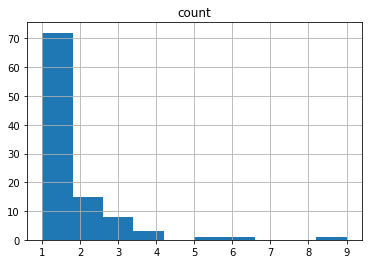

In [40]:
pd.DataFrame(data=obras_adjudicatario).rename(columns = {'Adjudicatario':'count'}, inplace = False).sort_values(by=["count"]).hist()

## c) Creación de archivos de nodos y relaciones para transferir a un grafo en Neo4j

En esta sección, se generan los insumos que se requieren para alimentar un grafo que permita analizar los datos a través de técnicas como el análisis de redes sociales. Para el diseño del modelo del grafo se tomó como referencia los campos formales del Estándar de Datos para las Contrataciones Abiertas (Open Contracting Partnertship, 2020) y una ontología para compra pública sugerida por el proyecto europeo TheyBuyForYou (Soylu et al., 2019) para llegar al grafo mostrado en la siguiente figura. 

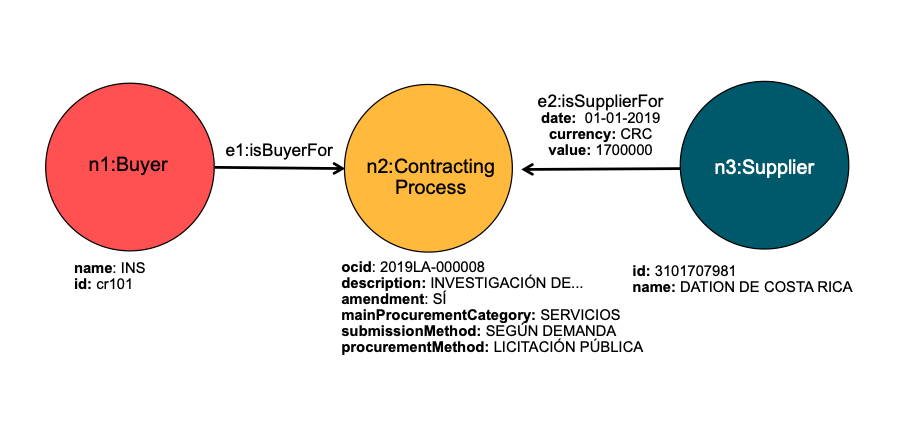

In [41]:
Image("graph.png")

El nodo es la unidad fundamental del grafo y se representa con un círculo y sus etiquetas. Los arcos son líneas direccionales que conectan pares de nodos. Tanto los nodos como los arcos pueden tener propiedades asociadas que ayudan a describirlos. A partir de esta especificación se construye un modelo de grafo con tres tipos de nodos: Institution (institución), ContractingProcess (procedimiento de contratación) y Supplier (proveedor). De los nodos que representan a las instituciones se proyectan arcos de tipo isBuyerFor hacia los procedimientos tramitados por ellas. De igual modo, de los nodos que representan a los proveedores se dirigen arcos (identificados con la etiqueta isSupplierFor) hacia los procedimientos adjudicados. De un mismo procedimiento de contratación se pueden derivar contratos hacia múltiples proveedores. Nótese que los nombres de las etiquetas están en inglés debido a que así lo especifica el estándar. La información sobre los contratos individuales está contenida en las propiedades de los arcos de tipo isSupplierFor. Las generalidades del modelo fueron validadas por un periodista especializado en casos de corrupción en la contratación pública.

Creación de nodos de procesos de Instituciones Compradoras (:Buyer)

In [42]:
buyer=obra_publica[["Institución"]].drop_duplicates().reset_index().rename(columns = {"index":"id","Institución":"name"}, inplace = False)
buyer

,id,name
0,0,Municipalidad de Cartago
1,3,Municipalidad del Cantón de Flores
2,210,Municipalidad de Alajuela
3,232,MUNICIPALIDAD DE MATINA
4,295,Municipalidad de Atenas
5,457,MUNICIPALIDAD DE SAN RAFAEL DE HEREDIA
6,601,Municipalidad de Curridabat
7,607,COMISION NACIONAL DE PREVENCION DE RIESGOS Y A...
8,705,Municipalidad de Santa Cruz
9,716,COLEGIO UNIVERSITARIO DE CARTAGO


Creación de nodos de Procesos de Contratación (:ContractingProcess)

In [43]:
contractingProcess=obra_publica[["Número contrato","Descripción","Modificaciones","Clasificación objeto","Tipo modalidad","Tipo Procedimiento"]].drop_duplicates().rename(columns = {"Número contrato":"ocid","Descripción":"description","Modificaciones":"amendment","Clasificación objeto":"mainProcurementCategory","Tipo modalidad":"submissionMethod","Tipo Procedimiento":"procurementMethod"}, inplace = False)
contractingProcess

,ocid,description,amendment,mainProcurementCategory,submissionMethod,procurementMethod
0,432020030400427,Obra publica construcción de tapia perimetral ...,Sí,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA
3,432020000700043,Construcción e instalación de malla perimetral...,Sí,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA
144,432020030400404,Obra publica construcción de tapia perimetral ...,Sí,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA
210,432020002500374,CENTRO DE REHABILITACION Y EXTENSION COMUNAL,Sí,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA
232,432020010600063,Proyecto Rehabilitación y Mejoras en La Superf...,Sí,OBRA PUBLICA,Según demanda,LICITACIÓN PÚBLICA NACIONAL
...,...,...,...,...,...,...
13272,432020002900207,UTGVM-014-2020 MANTENIMIENTO Y MEJORAMIENTO VI...,No,OBRA PUBLICA,Cantidad definida,LICITACIÓN ABREVIADA
13274,432020002900208,Perforación de tres pozos para el departamento...,Sí,OBRA PUBLICA,Cantidad definida,LICITACIÓN ABREVIADA
13282,432020120400001,MEJORAS INFRAESTRUCTURA COLEGIO TAMBOR,Sí,OBRA PUBLICA,Cantidad definida,PROCEDIMIENTO POR PRINCIPIO
13605,432020005700004,21400007 MEJORAS AL REBOMBEO AYA TILARÁN REGIÓ...,No,OBRA PUBLICA,Cantidad definida,CONTRATACIÓN DIRECTA


Creación de nodos de Adjudicatarios (:Supplier)

In [44]:
supplier=obra_publica[["Cédula adjudicatario","Adjudicatario"]].drop_duplicates().rename(columns = {"Cédula adjudicatario":"id","Adjudicatario":"name"}, inplace = False)
supplier

,id,name
0,3101526300,BIENES AHT DE COSTA RICA SOCIEDAD ANONIMA
3,3101068932,LA NUEVA UNION FERRETERA DE SAN JOSE SOCIEDAD ...
144,3101258822,SOLUCIONES DE INGENIERIA SOCIEDAD ANONIMA
210,3101664974,SOLUCIONES INTEGRALES MEYCI SOCIEDAD ANONIMA
232,3101035078,CONSTRUCTORA MECO SOCIEDAD ANONIMA
...,...,...
12921,3101667259,RQL INGENIERIA SOCIEDAD ANONIMA
13177,3101026507,CONSULTORA COSTARRICENSE PARA PROGRAMAS DE DES...
13274,1202001235,Consorcio Pura Vida-Alrotek-2020
13605,1202001361,Consorcio RQL INGENIERÍA S.A - ELECTROBEYCO S.A.


Creación de relaciones entre nodos de Instituciones Compradoras y Procesos de Contratación
(:isBuyerFor)

In [45]:
isBuyerFor=obra_publica[["Institución","Número contrato"]].rename(columns = {"Institución":"name","Número contrato":"ocid"}, inplace = False)
isBuyerFor

,name,ocid
0,Municipalidad de Cartago,432020030400427
3,Municipalidad del Cantón de Flores,432020000700043
144,Municipalidad de Cartago,432020030400404
210,Municipalidad de Alajuela,432020002500374
232,MUNICIPALIDAD DE MATINA,432020010600063
...,...,...
13272,Municipalidad de Paraíso,432020002900207
13274,Municipalidad de Paraíso,432020002900208
13282,Junta Administrativa liceo de Tambor,432020120400001
13605,Instituto Costarricense de Acueductos y Alcant...,432020005700004


Creación de relaciones entre nodos de Adjudicatarios y Procesos de Contratación
(:isSupplierFor)

In [46]:
isSupplierFor=obra_publica[["Cédula adjudicatario","Número contrato"]].rename(columns = {"Cédula adjudicatario":"id","Número contrato":"ocid"}, inplace = False)
isSupplierFor

,id,ocid
0,3101526300,432020030400427
3,3101068932,432020000700043
144,3101258822,432020030400404
210,3101664974,432020002500374
232,3101035078,432020010600063
...,...,...
13272,3101008650,432020002900207
13274,1202001235,432020002900208
13282,3101627955,432020120400001
13605,1202001361,432020005700004


### Referencias

Open Contracting Partnertship. (2020). Open Contracting Data Standard. Recuperado de https://standard.open-contracting.org/latest/en/ 

Soylu, A., Elvesæter, B., Turk, P., Roman, D., Corcho, O., Simperi, E., Konstantinidis, G., & Lech, T. C. (2019, setiembre). Towards an Ontology for Public Procurement Based on the Open Contracting Data Standard. 18th Conference on e-Business, e-Services and e-Society (I3E), Trondheim, Norway. https://doi.org/10.1007/978-3-030-29374-1_19